# Define Spark session

In [1]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, DateType
from pyspark.sql.window import Window
from pyspark.sql import functions as F

In [2]:
spark = SparkSession.builder.appName("HCHO Analysis").config("spark.memory.offHeap.enabled","true").config("spark.memory.offHeap.size","200m").getOrCreate()

# 1. Preprocess

## 1.1 Clean and prepare the data

In [3]:
schema = StructType([
    StructField("HCHO_reading", DoubleType(), True),
    StructField("Location", StringType(), True),
    StructField("Current_Date", DateType(), True),
    StructField("Next_Date", DateType(), True),
])

#### import combine dataset

In [4]:
df1 = spark.read.csv('Dataset/col_mat_nuw_output.csv', header=False, schema = schema,escape="\"")
df2 = spark.read.csv('Dataset/kan_output.csv', header=False, schema = schema,escape="\"")
df3 = spark.read.csv('Dataset/mon_kur_jaf_output.csv', header=False, schema = schema,escape="\"")

In [5]:
df1_and_df2 = df1.union(df2)
combined_df = df1_and_df2.union(df3)

In [6]:
combined_df.show(5)

+--------------------+--------------+------------+----------+
|        HCHO_reading|      Location|Current_Date| Next_Date|
+--------------------+--------------+------------+----------+
|1.969834395781014...|Colombo Proper|  2019-01-01|2019-01-02|
|2.625522171968594...|Colombo Proper|  2019-01-02|2019-01-03|
|9.852118897938794E-5|Colombo Proper|  2019-01-03|2019-01-04|
|2.099320518114242E-4|Colombo Proper|  2019-01-04|2019-01-05|
|1.785337298892930...|Colombo Proper|  2019-01-05|2019-01-06|
+--------------------+--------------+------------+----------+


In [7]:
combined_df = combined_df.select('HCHO_reading','Location', 'Current_Date')

In [8]:
combined_df.printSchema()

root
 |-- HCHO_reading: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- Current_Date: date (nullable = true)


In [9]:
combined_df.count()

12782

In [10]:
# check for null values
for column in combined_df.columns:
    print(f"Null Values in {column} : {combined_df.filter(combined_df[column].isNull()).count()}")

Null Values in HCHO_reading : 4864
Null Values in Location : 0
Null Values in Current_Date : 0


In [11]:
# replace negative values with null values
combined_df = combined_df.withColumn('HCHO_reading',F.when(combined_df['HCHO_reading'] < 0, None).otherwise(combined_df['HCHO_reading']))

In [12]:
combined_df.count()

12782

#### fill null values forward fill

In [13]:
windowSpec = Window.partitionBy("Location").orderBy("Current_Date")
combined_df = combined_df.withColumn("HCHO_reading", F.last("HCHO_reading", True).over(windowSpec))

# fill the remaining null values with mean
mean_hcho = combined_df.select(F.mean(combined_df["HCHO_reading"])).collect()[0][0]
combined_df = combined_df.fillna(mean_hcho, subset=["HCHO_reading"])

#### remove outliers

In [14]:
# Define the window specification for partitioning
windowSpec = Window.partitionBy("Location").orderBy("HCHO_reading")

# Calculate quartiles (Q1 and Q3) and IQR
combined_df = combined_df.withColumn("Q1", F.expr("percentile_approx(HCHO_reading, 0.25)").over(windowSpec))
combined_df = combined_df.withColumn("Q3", F.expr("percentile_approx(HCHO_reading, 0.75)").over(windowSpec))
combined_df = combined_df.withColumn("IQR", F.col("Q3") - F.col("Q1"))

# Calculate lower and upper bounds for outlier detection
combined_df = combined_df.withColumn("lower_bound", F.col("Q1") - 1.5 * F.col("IQR"))
combined_df = combined_df.withColumn("upper_bound", F.col("Q3") + 1.5 * F.col("IQR"))

# Filter out outliers
combined_df = combined_df.filter((F.col("HCHO_reading") >= F.col("lower_bound")) & (F.col("HCHO_reading") <= F.col("upper_bound")))
combined_df = combined_df.drop('Q1','Q3','IQR','lower_bound','upper_bound')

In [15]:
combined_df.count()

12444

In [16]:
null_rows = combined_df.filter(combined_df["HCHO_reading"].isNull())
null_rows.show()

+------------+--------+------------+
|HCHO_reading|Location|Current_Date|
+------------+--------+------------+
+------------+--------+------------+


## 1.2 Explore descriptive statistics

In [17]:
summary_df = combined_df.describe()
summary_df.show()

+-------+--------------------+-------------------+
|summary|        HCHO_reading|           Location|
+-------+--------------------+-------------------+
|  count|               12444|              12444|
|   mean|1.209523078923467...|               NULL|
| stddev|7.253024460841794E-5|               NULL|
|    min|8.485600456102689E-8| Bibile, Monaragala|
|    max|3.906452278091737...|Nuwara Eliya Proper|
+-------+--------------------+-------------------+


#### statistics by location

In [18]:
# Calculate descriptive statistics by city
city_stats = combined_df.groupBy('Location') \
                         .agg(F.mean('HCHO_reading').alias('Mean_HCHO'),
                              F.median('HCHO_reading').alias('Median_HCHO'),
                              F.stddev('HCHO_reading').alias('StdDev_HCHO')) \
                         .orderBy('Location')
city_stats.show()

+-------------------+--------------------+--------------------+--------------------+
|           Location|           Mean_HCHO|         Median_HCHO|         StdDev_HCHO|
+-------------------+--------------------+--------------------+--------------------+
| Bibile, Monaragala|1.283725509765170...|1.232948475055256...|7.399431231170369E-5|
|     Colombo Proper|1.571356435763037E-4|1.469398412098353...|8.344129729365464E-5|
|   Deniyaya, Matara|1.029956269165208...|9.172827110939618E-5|6.579683811338116E-5|
|      Jaffna Proper|1.048386124789734...|9.895708212557492E-5|5.555937695376365...|
|       Kandy Proper|1.141820058384229...|1.121623803096215...|6.859031441324259E-5|
|  Kurunegala Proper|1.338910846564295E-4|1.237540495612417...|7.095582058734577E-5|
|Nuwara Eliya Proper|1.045469089560357...|9.700647998926193E-5|6.896848623846392E-5|
+-------------------+--------------------+--------------------+--------------------+


In [19]:
overall_stats = combined_df.agg(F.mean('HCHO_reading').alias('Overall_Mean_HCHO'),
                                F.median('HCHO_reading').alias('Overall_Median_HCHO'),
                                F.stddev('HCHO_reading').alias('Overall_StdDev_HCHO'))

overall_stats.show()

+--------------------+--------------------+--------------------+
|   Overall_Mean_HCHO| Overall_Median_HCHO| Overall_StdDev_HCHO|
+--------------------+--------------------+--------------------+
|1.209523078923467...|1.121925032230766...|7.253024460841794E-5|
+--------------------+--------------------+--------------------+


## 1.3 Visualize data distribution

#### hcho distribution histogram by location

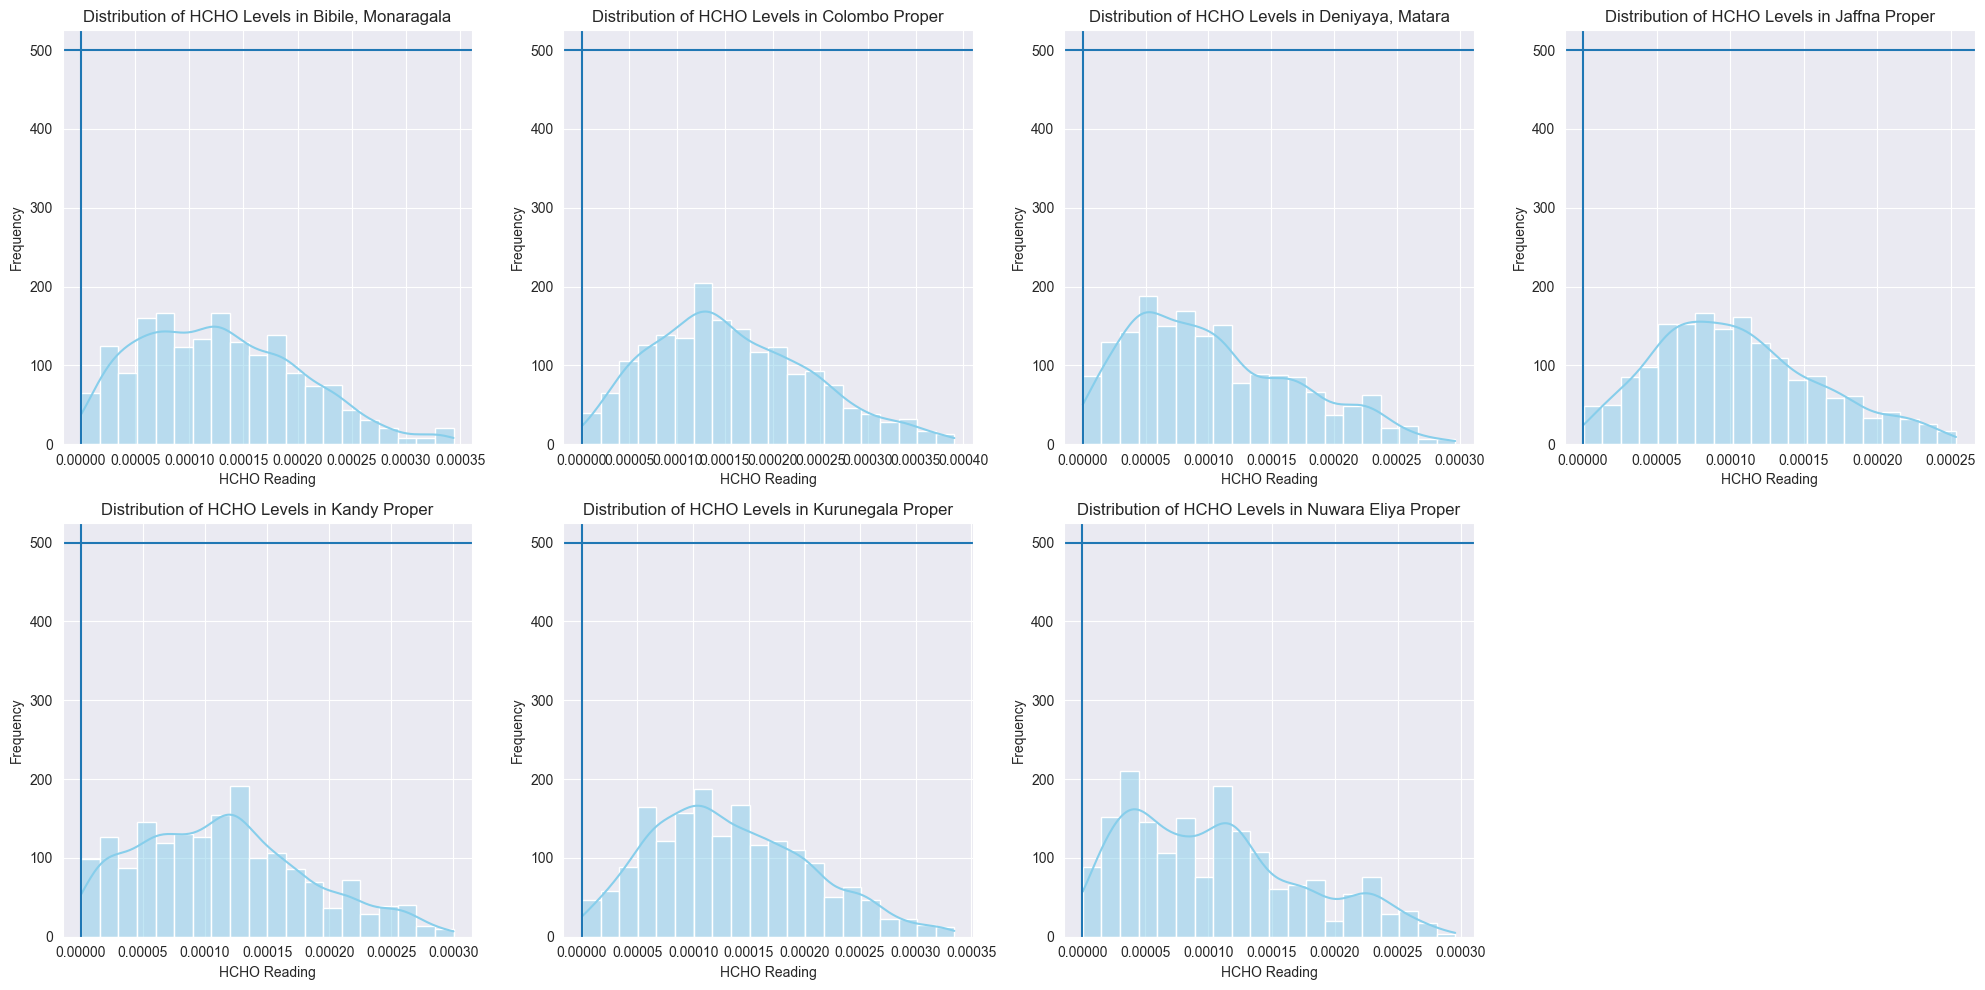

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

location_groups = combined_df.groupBy('location').agg(F.collect_list('HCHO_reading').alias('HCHO_list'))

# Convert PySpark DataFrame to Pandas DataFrame for visualization
pandas_df = location_groups.toPandas()

# Define number of rows and columns for subplot grid
num_rows = 2
num_cols = 4

# Calculate total number of subplots and iterate over locations
total_subplots = num_rows * num_cols

# Create a new figure and set the figure size
plt.figure(figsize=(20, 10))

# Loop through each location and plot histogram in a subplot
for i, row in pandas_df.iterrows():
    if i >= total_subplots:
        break  # Break loop if total subplots limit is reached
    
    location = row['location']
    hcho_readings = row['HCHO_list']
    
    # Calculate subplot position (1-indexed)
    subplot_index = i + 1
    
    # Create subplot for current location
    plt.subplot(num_rows, num_cols, subplot_index)
    sns.histplot(hcho_readings, bins=20, kde=True, color='skyblue')
    plt.axhline(500)
    plt.axvline(0)
    plt.title(f"Distribution of HCHO Levels in {location}")
    plt.xlabel("HCHO Reading")
    plt.ylabel("Frequency")


plt.tight_layout()
plt.show()

#### hcho distibution box plots

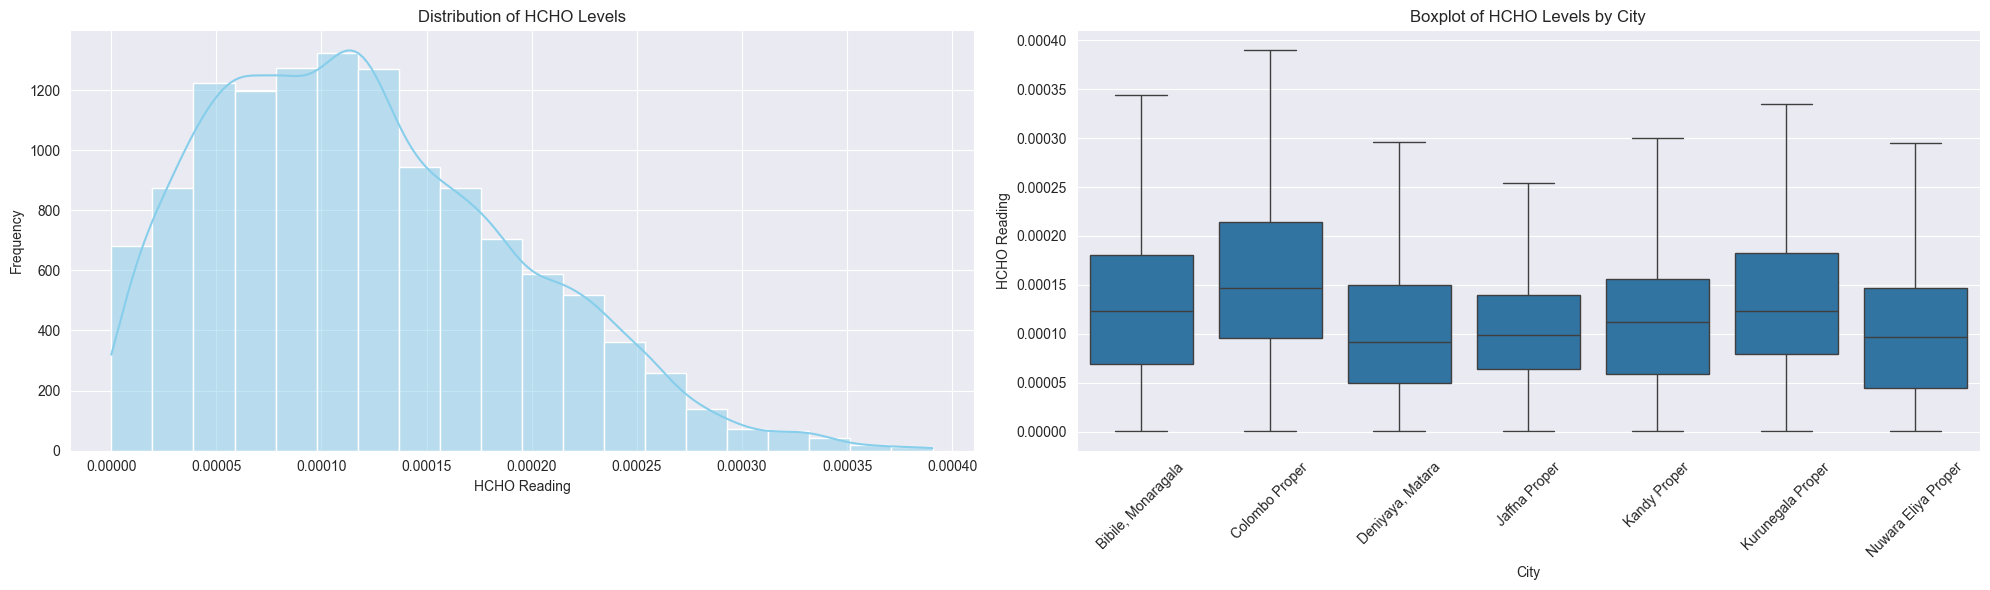

In [21]:
pandas_df = combined_df.toPandas().dropna()
plt.figure(figsize=(20, 6))

# Create histogram
plt.subplot(1, 2, 1)
sns.histplot(pandas_df['HCHO_reading'], bins=20, kde=True, color='skyblue')
plt.title("Distribution of HCHO Levels")
plt.xlabel("HCHO Reading")
plt.ylabel("Frequency")

# Create boxplot by city
plt.subplot(1, 2, 2)
sns.boxplot(x='Location', y='HCHO_reading', data=pandas_df)
plt.title("Boxplot of HCHO Levels by City")
plt.xlabel("City")
plt.ylabel("HCHO Reading")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# 2. Spatio-Temporal Analysis

## 2.1 Analyse trends over time

#### hcho during covid

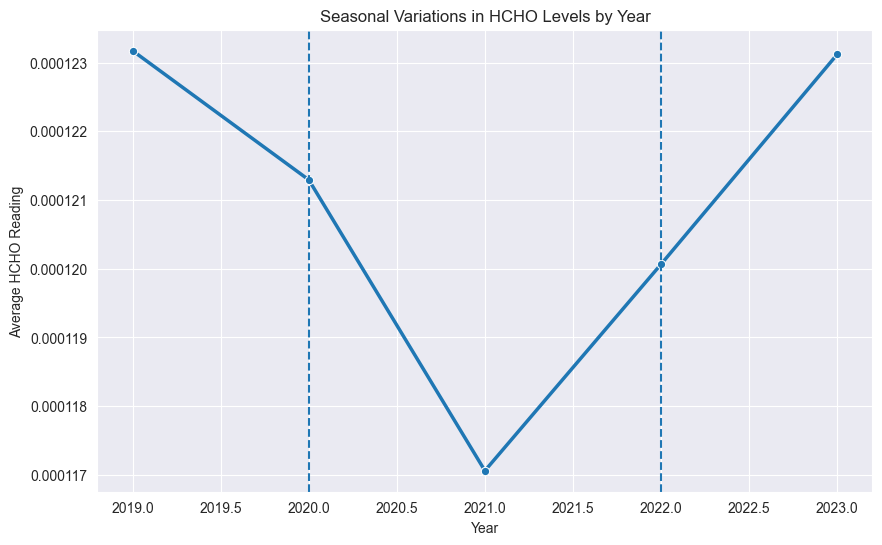

In [22]:
# Aggregate by year to calculate average HCHO readings
yearly_avg = combined_df.groupBy(F.year('Current_Date').alias('Year')) \
                          .agg(F.mean('HCHO_reading').alias('Avg_HCHO'))

# Convert aggregated DataFrame to Pandas for plotting
yearly_avg_pandas = yearly_avg.toPandas()

# Plot seasonal variations by year
plt.figure(figsize=(10, 6))
sns.lineplot(x=yearly_avg_pandas["Year"], y=yearly_avg_pandas["Avg_HCHO"], marker='o', linewidth=2.5)
plt.axvline(2020, linestyle='--')
plt.axvline(2022, linestyle='--')
plt.title('Seasonal Variations in HCHO Levels by Year')
plt.xlabel('Year')
plt.ylabel('Average HCHO Reading')
plt.grid(True)
plt.show()

#### hcho by month

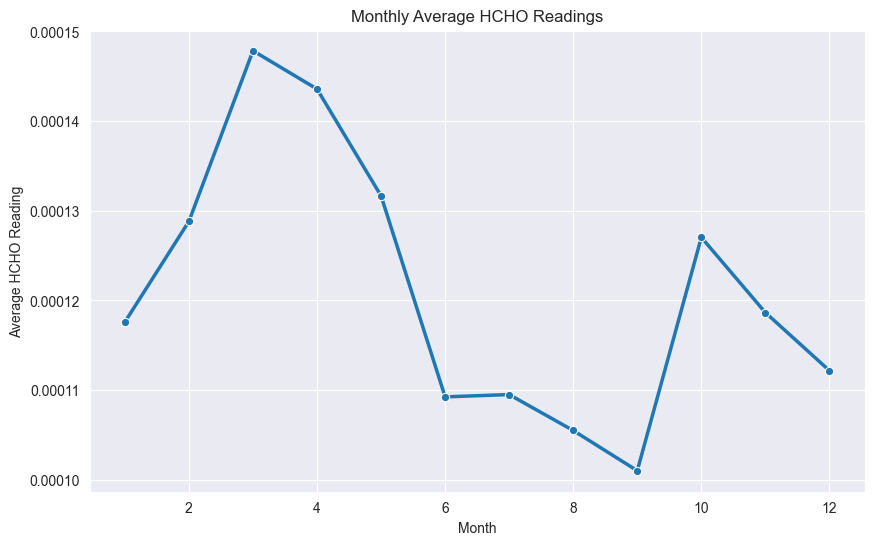

In [23]:
# Calculate monthly average HCHO readings
monthly_avg = combined_df.groupBy(F.month('Current_Date').alias('Month')) \
                          .agg(F.mean('HCHO_reading').alias('Avg_HCHO'))

# Convert aggregated DataFrame to Pandas for plotting
monthly_avg_pandas = monthly_avg.toPandas()

# Plot monthly average HCHO readings
plt.figure(figsize=(10, 6))
sns.lineplot(x=monthly_avg_pandas["Month"], y=monthly_avg_pandas["Avg_HCHO"], marker='o', linewidth=2.5)
plt.xlabel('Month')
plt.ylabel('Average HCHO Reading')
plt.title('Monthly Average HCHO Readings')
plt.show()

#### hcho by month and year

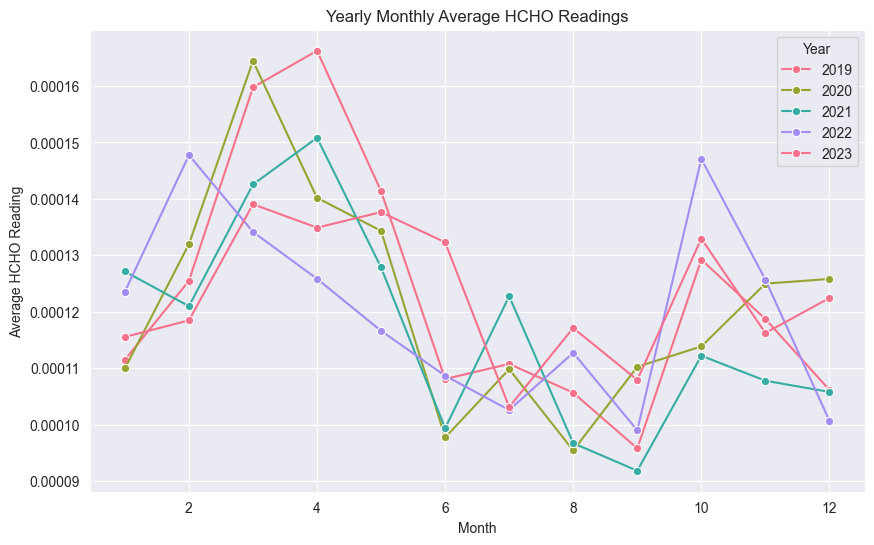

In [24]:
# Calculate monthly average HCHO readings by year and month
yearly_monthly_avg = combined_df.groupBy(F.year('Current_Date').alias('Year'), F.month('Current_Date').alias('Month')) \
                                 .agg(F.mean('HCHO_reading').alias('Avg_HCHO'))


# Convert aggregated DataFrame to Pandas
yearly_monthly_avg_pandas = yearly_monthly_avg.toPandas()

# Plot yearly monthly HCHO readings
plt.figure(figsize=(10, 6))
sns.lineplot(x="Month", y="Avg_HCHO", hue="Year", data=yearly_monthly_avg_pandas, marker='o', linewidth=1.5, palette='husl')
plt.title('Yearly Monthly Average HCHO Readings')
plt.xlabel('Month')
plt.ylabel('Average HCHO Reading')
plt.legend(title='Year')
plt.grid(True)
plt.show()

## 2.2  Correlate HCHO levels with external factors

#### clean weather data

In [25]:
schema = StructType([
    StructField("STATION", StringType(), nullable=True),
    StructField("NAME", StringType(), nullable=True),
    StructField("LATITUDE", DoubleType(), nullable=True),
    StructField("LONGITUDE", DoubleType(), nullable=True),
    StructField("ELEVATION", DoubleType(), nullable=True),
    StructField("DATE", DateType(), nullable=True),
    StructField("PRCP", DoubleType(), nullable=True),
    StructField("PRCP_ATTRIBUTES", StringType(), nullable=True),
    StructField("SNWD", DoubleType(), nullable=True),
    StructField("SNWD_ATTRIBUTES", StringType(), nullable=True),
    StructField("TAVG", DoubleType(), nullable=True),
    StructField("TAVG_ATTRIBUTES", StringType(), nullable=True),
    StructField("TMAX", DoubleType(), nullable=True),
    StructField("TMAX_ATTRIBUTES", StringType(), nullable=True),
    StructField("TMIN", DoubleType(), nullable=True),
    StructField("TMIN_ATTRIBUTES", StringType(), nullable=True)
])

In [26]:
weather_df = spark.read.csv('Dataset/3657144.csv', header=True, escape="\"", schema=schema)

In [27]:
weather_df.printSchema()

root
 |-- STATION: string (nullable = true)
 |-- NAME: string (nullable = true)
 |-- LATITUDE: double (nullable = true)
 |-- LONGITUDE: double (nullable = true)
 |-- ELEVATION: double (nullable = true)
 |-- DATE: date (nullable = true)
 |-- PRCP: double (nullable = true)
 |-- PRCP_ATTRIBUTES: string (nullable = true)
 |-- SNWD: double (nullable = true)
 |-- SNWD_ATTRIBUTES: string (nullable = true)
 |-- TAVG: double (nullable = true)
 |-- TAVG_ATTRIBUTES: string (nullable = true)
 |-- TMAX: double (nullable = true)
 |-- TMAX_ATTRIBUTES: string (nullable = true)
 |-- TMIN: double (nullable = true)
 |-- TMIN_ATTRIBUTES: string (nullable = true)


In [28]:
windowSpec = Window.partitionBy("Name").orderBy("Date")
weather_df = weather_df.withColumn('TAVG_temp', F.when(F.col('TAVG').isNull(),(F.col('TMAX') + F.col('TMIN')) / 2).otherwise(F.col('TAVG')))
weather_df = weather_df.withColumn('PRCP',F.last("PRCP", True).over(windowSpec))

In [29]:
weather_df = weather_df.select('NAME','DATE', 'ELEVATION','LATITUDE' ,'LONGITUDE','PRCP', 'TAVG')

In [30]:
weather_df.describe().show()

+-------+----------------+------------------+-------------------+------------------+-------------------+------------------+
|summary|            NAME|         ELEVATION|           LATITUDE|         LONGITUDE|               PRCP|              TAVG|
+-------+----------------+------------------+-------------------+------------------+-------------------+------------------+
|  count|           66150|             66150|              66150|             66150|              31167|             25947|
|   mean|            NULL|1543.6686621315193|  6.996007619051226| 80.63801133786109|0.18625918439375197| 70.63857093305585|
| stddev|            NULL| 709.1011128682371|0.13370395049520403|0.2913366443495017| 0.5698609133040519|11.053510133173749|
|    min|     COLOMBO, CE|               7.0|                6.9|            79.867|                0.0|              49.0|
|    max|NUWARA ELIYA, CE|            1880.0|              7.467|            80.767|              18.98|              93.0|
+-------

In [31]:
rename_map = {
    'NAME': 'Location',
    'DATE': 'Current_Date',
    'ELEVATION': 'Elevation',
    'LATITUDE': 'Latitude',
    'LONGITUDE': 'Longitude',
    'PRCP': 'Precipitation',
    'TAVG': 'Temperature'
}

# Rename column name
for old_name, new_name in rename_map.items():
    weather_df = weather_df.withColumnRenamed(old_name, new_name)

In [32]:
location_map = {'KURUNEGALA, CE':'Kurunegala Proper',
                'COLOMBO, CE':'Colombo Proper',
                'NUWARA ELIYA, CE':'Nuwara Eliya Proper'}

for old_name, new_name in location_map.items():
    weather_df = weather_df.replace(old_name, new_name, 'Location')

In [33]:
weather_df.show(5)

+--------------+------------+---------+--------+---------+-------------+-----------+
|      Location|Current_Date|Elevation|Latitude|Longitude|Precipitation|Temperature|
+--------------+------------+---------+--------+---------+-------------+-----------+
|Colombo Proper|  1956-01-18|      7.0|     6.9|   79.867|         NULL|       77.0|
|Colombo Proper|  1957-07-01|      7.0|     6.9|   79.867|         1.12|       78.0|
|Colombo Proper|  1957-07-02|      7.0|     6.9|   79.867|         0.35|       80.0|
|Colombo Proper|  1957-07-03|      7.0|     6.9|   79.867|         0.35|       78.0|
|Colombo Proper|  1957-07-04|      7.0|     6.9|   79.867|         0.35|       79.0|
+--------------+------------+---------+--------+---------+-------------+-----------+


In [34]:
combined_weather_df = combined_df.join(weather_df, ['Location', 'Current_Date'], 'left')
combined_weather_df.show(5)

+------------------+------------+--------------------+---------+--------+---------+-------------+-----------+
|          Location|Current_Date|        HCHO_reading|Elevation|Latitude|Longitude|Precipitation|Temperature|
+------------------+------------+--------------------+---------+--------+---------+-------------+-----------+
|Bibile, Monaragala|  2021-06-14|1.461231683165326...|     NULL|    NULL|     NULL|         NULL|       NULL|
|Bibile, Monaragala|  2022-08-11|2.286542581525805...|     NULL|    NULL|     NULL|         NULL|       NULL|
|Bibile, Monaragala|  2022-03-12|3.306949904638596...|     NULL|    NULL|     NULL|         NULL|       NULL|
|Bibile, Monaragala|  2023-07-03|4.458375696591515E-6|     NULL|    NULL|     NULL|         NULL|       NULL|
|Bibile, Monaragala|  2023-07-04|4.458375696591515E-6|     NULL|    NULL|     NULL|         NULL|       NULL|
+------------------+------------+--------------------+---------+--------+---------+-------------+-----------+


In [35]:
for column in combined_weather_df.columns:
    print(f"Null Values in {column} : {combined_weather_df.filter(combined_weather_df[column].isNull()).count()}")

Null Values in Location : 0
Null Values in Current_Date : 0
Null Values in HCHO_reading : 0
Null Values in Elevation : 7312
Null Values in Latitude : 7312
Null Values in Longitude : 7312
Null Values in Precipitation : 7312
Null Values in Temperature : 7312


In [36]:
location_with_null_values = combined_weather_df.filter(combined_weather_df["elevation"].isNull()) \
                              .select("Location") \
                              .distinct()
location_with_null_values.show()

+-------------------+
|           Location|
+-------------------+
| Bibile, Monaragala|
|     Colombo Proper|
|   Deniyaya, Matara|
|      Jaffna Proper|
|       Kandy Proper|
|  Kurunegala Proper|
|Nuwara Eliya Proper|
+-------------------+


#### fill null value by forward fill

In [37]:
windowSpec = Window.partitionBy("Location")
combined_weather_df = combined_weather_df.withColumn("Elevation", F.last("Elevation", True).over(windowSpec)) \
                                         .withColumn("Latitude", F.last("Latitude", True).over(windowSpec)) \
                                         .withColumn("Longitude", F.last("Longitude", True).over(windowSpec))

#### add values gathered from online for elevation latitude and longitutde

In [38]:
location_details_map = {"Bibile, Monaragala": [263,7.11726,81.18449],
                        "Deniyaya, Matara": [451, 6.30256,80.52062],
                        "Jaffna Proper": [3, 9.6615, 80.0255],
                        "Kandy Proper": [621 , 7.13312, 80.47504]}

for location, (elevation, latitude, longitude) in location_details_map.items():
    combined_weather_df = combined_weather_df.withColumn("Elevation", F.when((combined_weather_df["Location"] == location) 
                                                                             & combined_weather_df["Elevation"].isNull(), elevation).otherwise(combined_weather_df["Elevation"]))\
                                             .withColumn("Latitude", F.when((combined_weather_df["Location"] == location) 
                                                                             & combined_weather_df["Latitude"].isNull(), latitude).otherwise(combined_weather_df["Latitude"]))\
                                             .withColumn("Longitude", F.when((combined_weather_df["Location"] == location) 
                                                                             & combined_weather_df["Longitude"].isNull(), longitude).otherwise(combined_weather_df["Longitude"]))

#### check for null values

In [39]:
for column in combined_weather_df.columns:
    print(f"Null Values in {column} : {combined_weather_df.filter(combined_weather_df[column].isNull()).count()}")

Null Values in Location : 0
Null Values in Current_Date : 0
Null Values in HCHO_reading : 0
Null Values in Elevation : 0
Null Values in Latitude : 0
Null Values in Longitude : 0
Null Values in Precipitation : 7312
Null Values in Temperature : 7312


In [40]:
filtered_df = combined_weather_df.filter(combined_weather_df["Location"] == "Colombo Proper")
filtered_df.show(5)

+--------------+------------+--------------------+---------+--------+---------+-------------+-----------+
|      Location|Current_Date|        HCHO_reading|Elevation|Latitude|Longitude|Precipitation|Temperature|
+--------------+------------+--------------------+---------+--------+---------+-------------+-----------+
|Colombo Proper|  2020-10-04|2.111934367094221...|      7.0|     6.9|   79.867|         0.01|       84.0|
|Colombo Proper|  2022-02-03|3.582195972256424E-7|      7.0|     6.9|   79.867|          0.0|       79.0|
|Colombo Proper|  2019-07-07|9.452725531817138E-7|      7.0|     6.9|   79.867|          0.0|       86.0|
|Colombo Proper|  2021-09-14|2.391585104770661E-6|      7.0|     6.9|   79.867|         0.24|       83.0|
|Colombo Proper|  2021-09-15|2.391585104770661E-6|      7.0|     6.9|   79.867|         0.02|       83.0|
+--------------+------------+--------------------+---------+--------+---------+-------------+-----------+


#### check correlation using heat map

<AxesSubplot: >

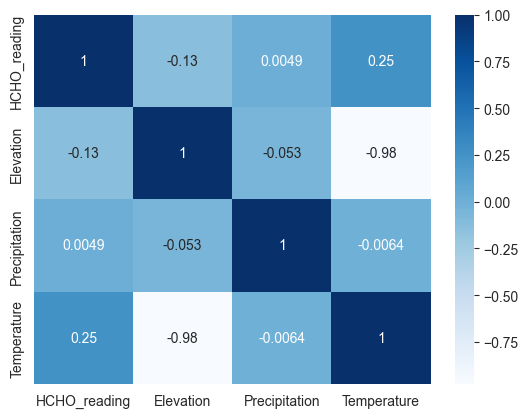

In [41]:
sns.heatmap(combined_weather_df.select('HCHO_reading','Elevation','Precipitation','Temperature').toPandas().corr(), annot=True, cmap='Blues')

## 2.3 Compare spatial patterns

#### check spatial patter using pair plot 

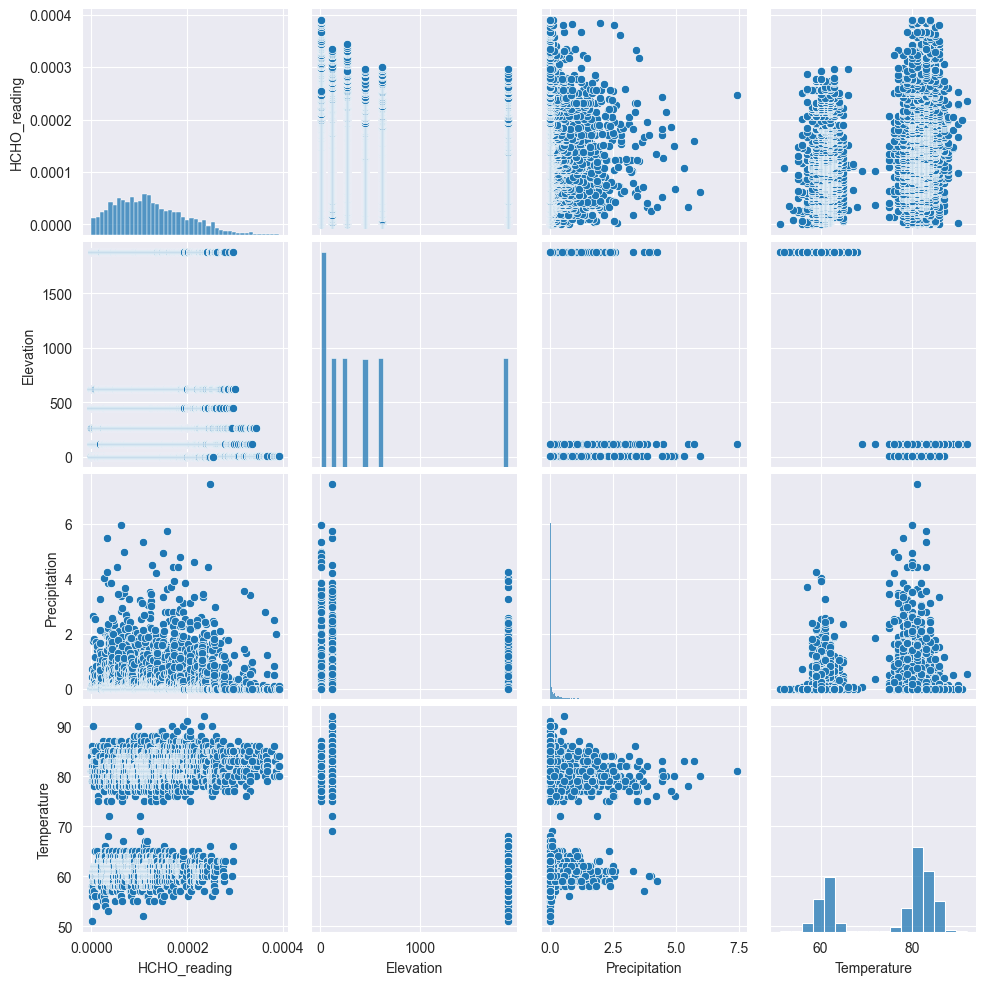

In [42]:
sns.pairplot(combined_weather_df.select('HCHO_reading','Elevation','Precipitation','Temperature').toPandas())

#### pair plot by location

<Figure size 1000x800 with 0 Axes>

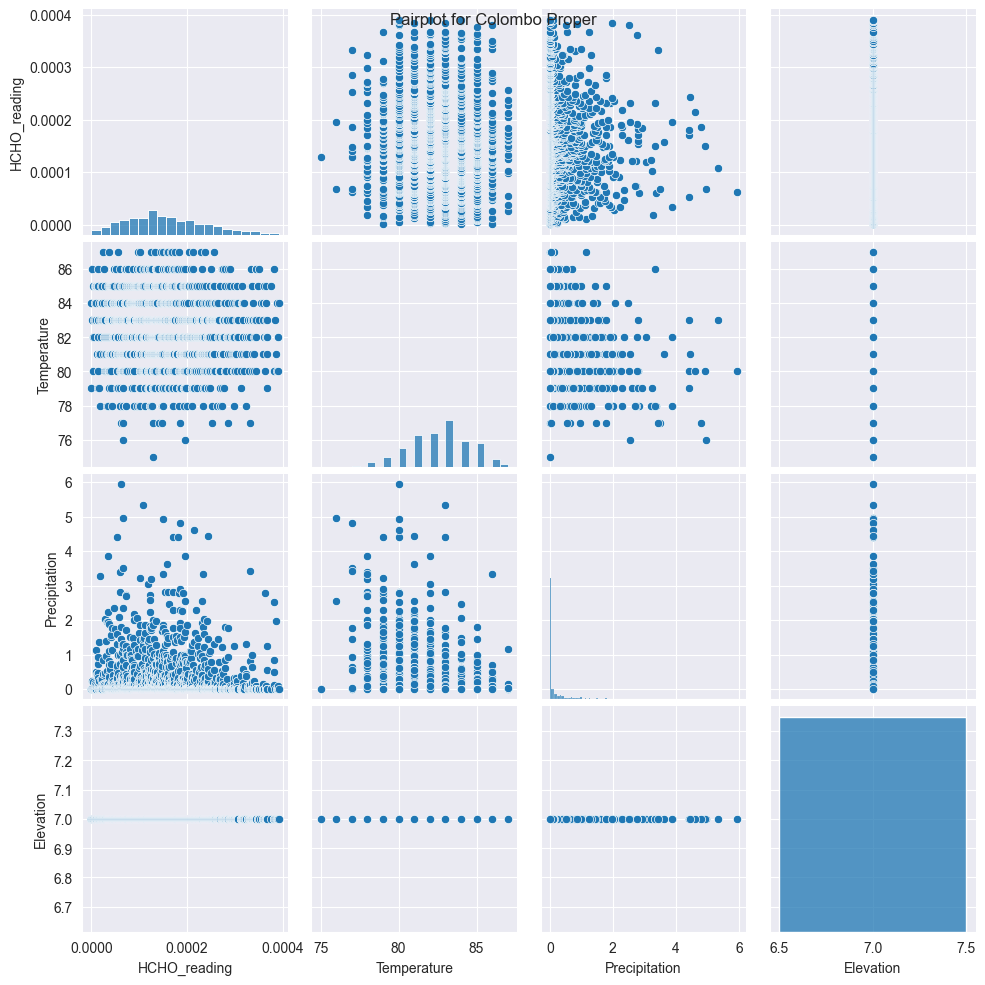

<Figure size 1000x800 with 0 Axes>

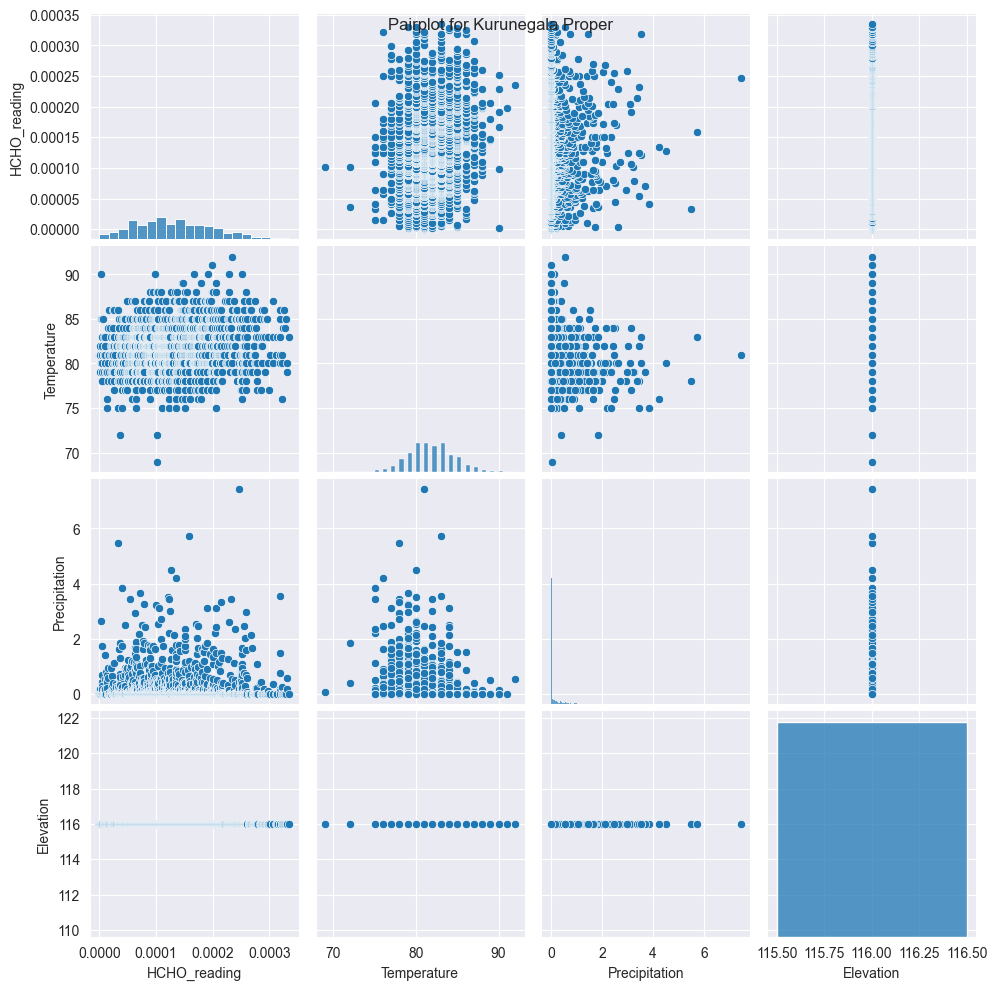

<Figure size 1000x800 with 0 Axes>

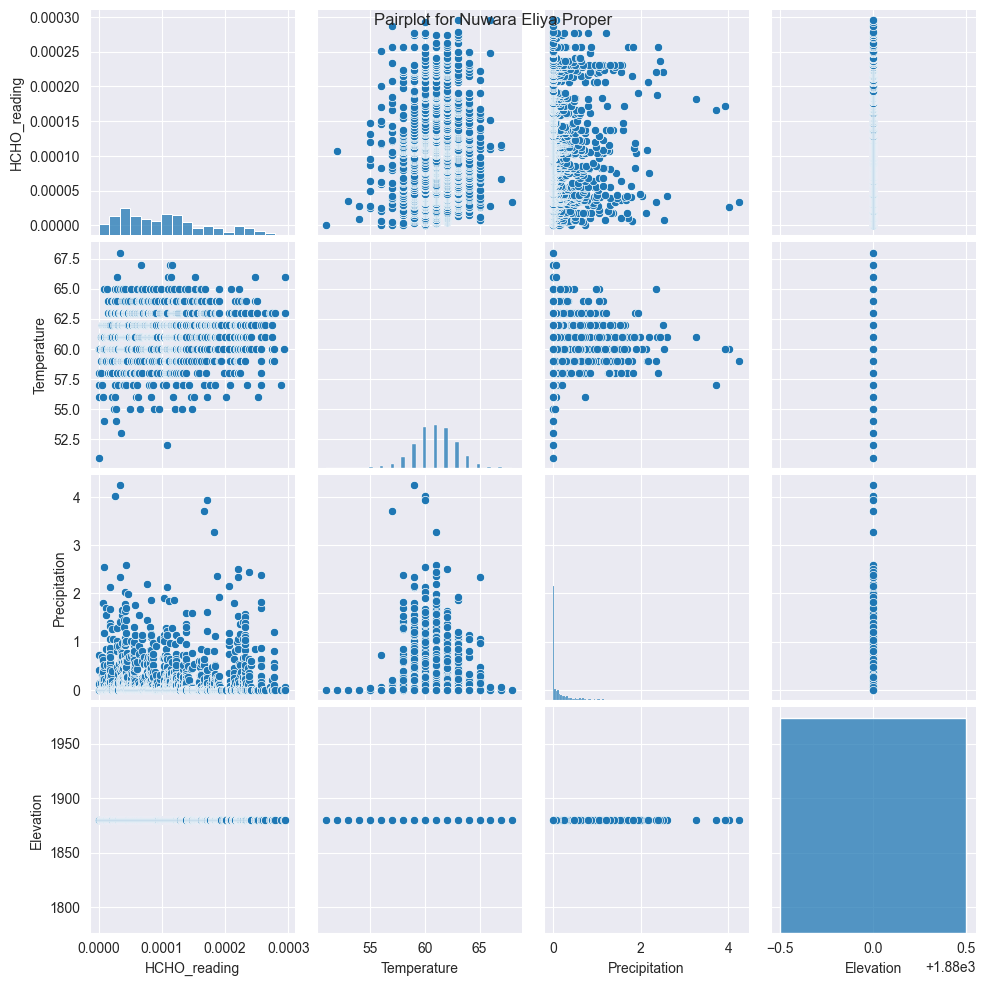

In [43]:
# Group data by Location
grouped_data = combined_weather_df.toPandas().groupby('Location')

# Iterate over each group and create pairplots
for location, data in grouped_data:
    if location in ['Colombo Proper', 'Kurunegala Proper', 'Nuwara Eliya Proper']:
        plt.figure(figsize=(10, 8))
        sns.pairplot(data, vars=['HCHO_reading', 'Temperature', 'Precipitation','Elevation'], diag_kind='hist')
        plt.suptitle(f'Pairplot for {location}')
        plt.show()

<Figure size 1200x1000 with 0 Axes>

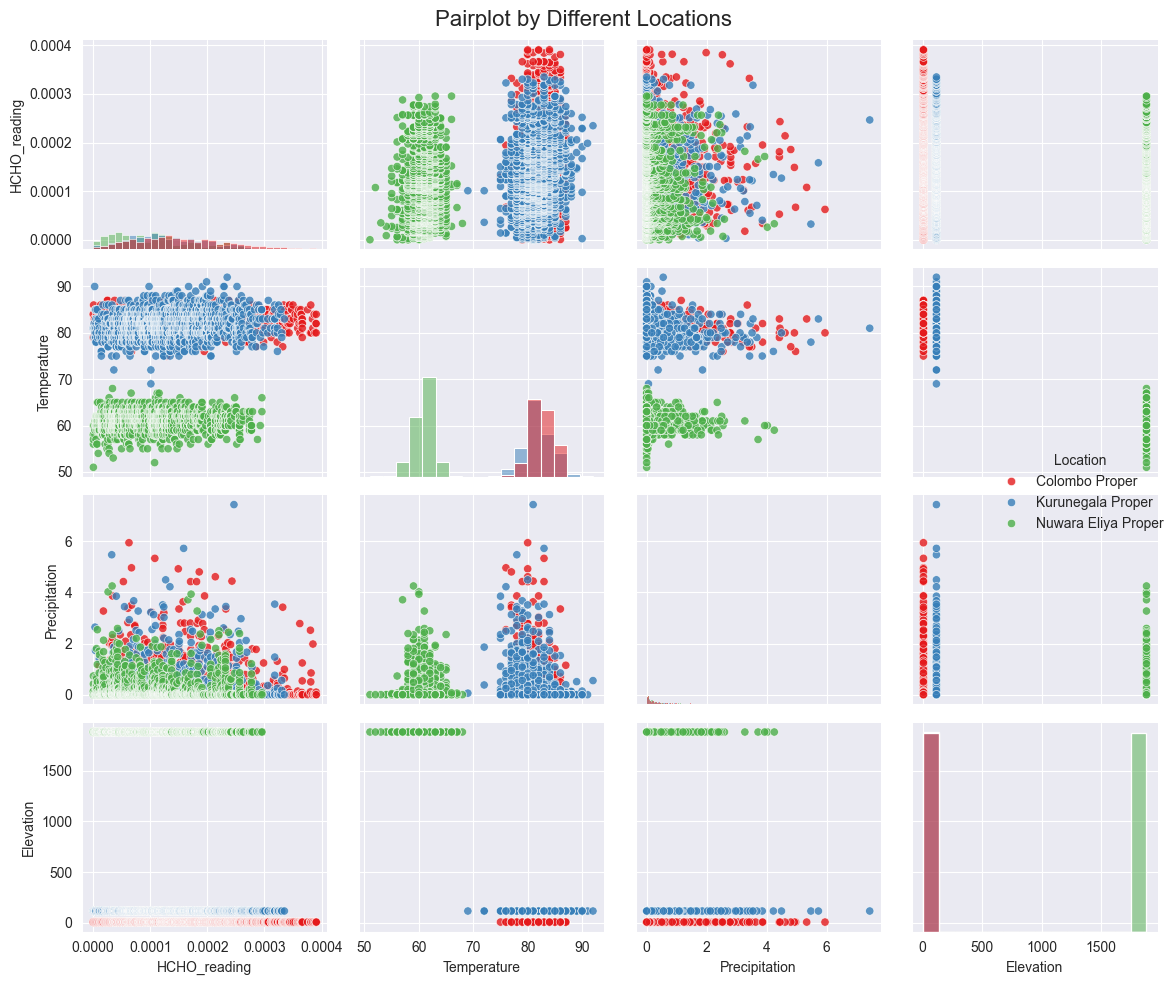

In [44]:
# Convert PySpark DataFrame to Pandas DataFrame
pandas_df = combined_weather_df.toPandas()

# Define the list of locations
locations_of_interest = ['Colombo Proper', 'Kurunegala Proper', 'Nuwara Eliya Proper']

# Filter the data for the selected locations
filtered_data = pandas_df[pandas_df['Location'].isin(locations_of_interest)]

# Set up the pair plot
plt.figure(figsize=(12, 10))
sns.pairplot(filtered_data, vars=['HCHO_reading', 'Temperature', 'Precipitation', 'Elevation'],
             hue='Location', palette='Set1', diag_kind='hist', plot_kws={'alpha': 0.8})

# Customize plot labels and title
plt.suptitle('Pairplot by Different Locations', fontsize=16)
plt.tight_layout()
plt.show()

# 3. Machine Learning

## 3.1 Develop a machine learning model

In [45]:
pandas_df = combined_weather_df.filter(combined_weather_df['Location'] == 'Colombo Proper').dropna().orderBy('Current_Date').toPandas()
pandas_df

,Location,Current_Date,HCHO_reading,Elevation,Latitude,Longitude,Precipitation,Temperature
0,Colombo Proper,2019-01-01,0.000197,7.0,6.9,79.867,0.00,81.0
1,Colombo Proper,2019-01-02,0.000263,7.0,6.9,79.867,0.00,78.0
2,Colombo Proper,2019-01-03,0.000099,7.0,6.9,79.867,0.00,81.0
3,Colombo Proper,2019-01-04,0.000210,7.0,6.9,79.867,0.00,81.0
4,Colombo Proper,2019-01-05,0.000179,7.0,6.9,79.867,0.00,81.0
...,...,...,...,...,...,...,...,...
1722,Colombo Proper,2023-12-27,0.000118,7.0,6.9,79.867,0.00,84.0
1723,Colombo Proper,2023-12-28,0.000118,7.0,6.9,79.867,0.07,82.0
1724,Colombo Proper,2023-12-29,0.000118,7.0,6.9,79.867,0.38,81.0
1725,Colombo Proper,2023-12-30,0.000140,7.0,6.9,79.867,0.10,81.0


#### set model params

In [46]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

pandas_df['Current_Date'] = pd.to_datetime(pandas_df['Current_Date'])
monthly_df = pandas_df.set_index('Current_Date')['HCHO_reading'].resample('M').mean()

# Split data into training (80%) and test (20%) sets
train_size = int(len(monthly_df) * 0.8)
train_data = monthly_df.iloc[:train_size]
test_data = monthly_df.iloc[train_size:]

# Set parameters
order = (1, 1, 1) 
seasonal_order = (1, 1, 1, 12) 

# Fit SARIMAX model using training data
model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order)
fitted_model = model.fit(maxiter=1000, method='powell')

C:\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Optimization terminated successfully.
         Current function value: -6.542864
         Iterations: 4
         Function evaluations: 570


## 3.2 Evaluate the model's performance

#### model summary

In [47]:
print(fitted_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                       HCHO_reading   No. Observations:                   48
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 314.057
Date:                            Sun, 21 Apr 2024   AIC                           -618.115
Time:                                    22:53:17   BIC                           -610.338
Sample:                                01-31-2019   HQIC                          -615.430
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1999   8.85e-20  -2.26e+18      0.000      -0.200      -0.200
ma.L1         -0.9511   4.67e-19  -

In [48]:
# Forecast future HCHO levels using the fitted model
forecast_steps = len(test_data)  # Forecasting for test data period
forecast = fitted_model.forecast(steps=forecast_steps)

# Create DataFrame for the forecasted values with corresponding dates
forecast_dates = pd.date_range(start=test_data.index[0], periods=forecast_steps, freq='M')
forecast_df = pd.DataFrame({'Forecasted_HCHO': forecast}, index=forecast_dates)

#### evaluate model

In [49]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate evaluation metrics using test data
mae = mean_absolute_error(test_data, forecast_df['Forecasted_HCHO'])
mse = mean_squared_error(test_data, forecast_df['Forecasted_HCHO'])
rmse = mean_squared_error(test_data, forecast_df['Forecasted_HCHO'], squared=False)
r2 = r2_score(test_data, forecast_df['Forecasted_HCHO'])

print("Forecast Accuracy Metrics:")
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2):", r2)

Forecast Accuracy Metrics:
Mean Absolute Error (MAE): 2.3990292958865587e-05
Mean Squared Error (MSE): 7.159681563867482e-10
Root Mean Squared Error (RMSE): 2.6757581288052704e-05
R-squared (R2): 0.5060216907839017


C:\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


#### model evaluation for test data

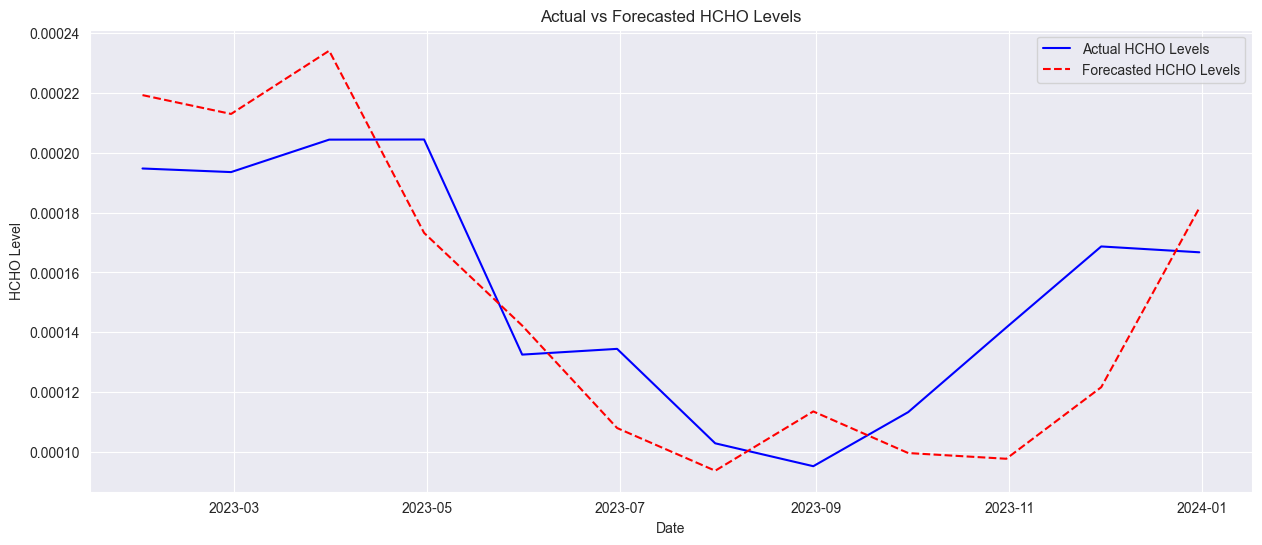

In [50]:
# Plot actual HCHO levels and forecasted values
plt.figure(figsize=(15, 6))
plt.plot(test_data.index, test_data, label='Actual HCHO Levels', color='blue')
plt.plot(forecast_df.index, forecast_df['Forecasted_HCHO'], label='Forecasted HCHO Levels', linestyle='--', color='red')
plt.title('Actual vs Forecasted HCHO Levels')
plt.xlabel('Date')
plt.ylabel('HCHO Level')
plt.legend()
plt.show()

#### model for future prediction

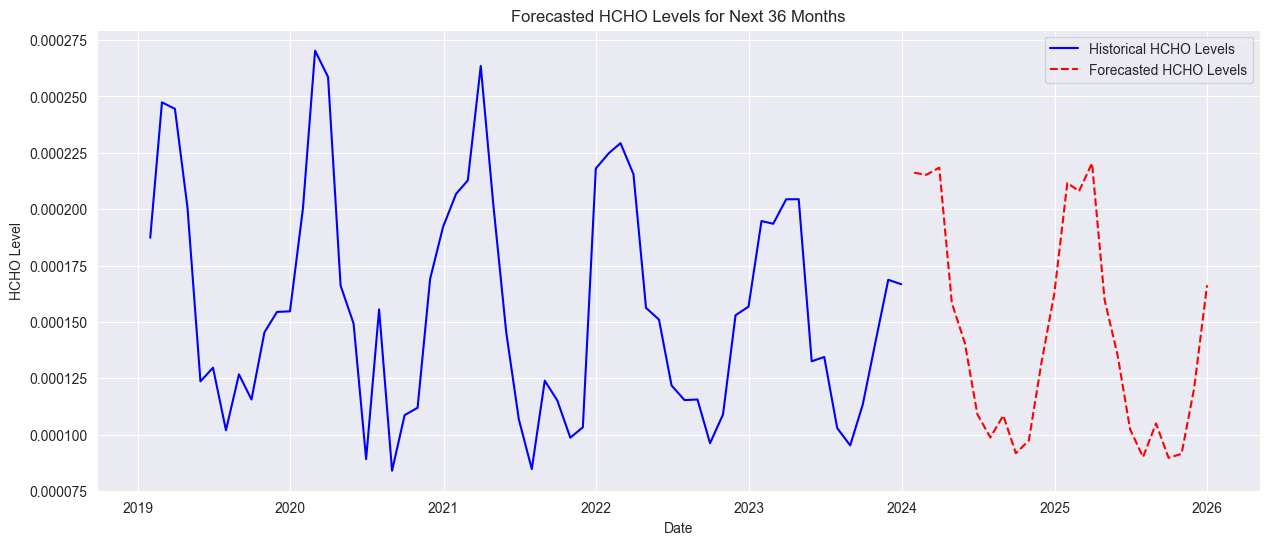

In [51]:
# Number of steps to forecast into the future
forecast_steps = 36 

# Forecast future HCHO levels beyond the existing data range
forecast = fitted_model.forecast(steps=forecast_steps)

# Create date range for the forecasted period
forecast_dates = pd.date_range(start=monthly_df.index[-1], periods=forecast_steps + 1, freq='M')[1:]
forecast_df = pd.DataFrame({'Forecasted_HCHO': forecast}, index=forecast_dates)

# Plot actual HCHO levels and forecasted values
plt.figure(figsize=(15, 6))
plt.plot(monthly_df.index, monthly_df, label='Historical HCHO Levels', color='blue')
plt.plot(forecast_df.index, forecast_df['Forecasted_HCHO'], label='Forecasted HCHO Levels', linestyle='--', color='red')
plt.title('Forecasted HCHO Levels for Next {} Months'.format(forecast_steps))
plt.xlabel('Date')
plt.ylabel('HCHO Level')
plt.legend()
plt.show()

# 4.Communication and Insights

## 4.1 Save Dataframe

In [52]:
combined_weather_df.toPandas().to_csv('Dataset/HCHO_Dataset.csv',index = False)

## 4.2 Create Power BI dashboard and Report

In [53]:
" The Power BI visualization and the Report are Completed and have been Submitted. "

' The Power BI visualization and the Report are Completed and have been Submitted. '

# Stop Spark session

In [54]:
spark.stop()